# Solving the Unit Commitment problem using Quantum Annealers
****

In this notebook, we aim to explore these limitations and assess the feasibility of using D-Wave's quantum annealers for solving the Unit Commitment (UC) problem. We will provide a simple formulation of the problem and investigate the capabilities of quantum annealing in terms of computational speed, solution quality, and scalability. By understanding the strengths and limitations of quantum annealing, we aim to contribute to the ongoing research and development efforts in the field of quantum computing for power plant scheduling.

## The unit commitmment problem

The Unit Commitment (UC) problem is a NP-hard optimization problem that aims at minimizing the operations of power generation units to meet electricity demand efficiently, while also taking into account factors such as start-up costs, ramping constraints, and minimum up/down times. The goal is to determine the optimal schedule for activating or deactivating power generation units over a specified time horizon [1].

Efficiently solving this is of paramount importance due to its potential to minimize costs, optimize resource usage, ensure energy security, mitigate environmental impact, stabilize energy prices, facilitate renewable integration, and prepare for future energy demands. In the absence of optimized UC, not only do inefficiencies lead to economic losses, but they also exacerbate environmental issues and hinder sustainable growth.

Recently, higher generation from renewable energy sources (RES) and more price responsive demand participation have made the UC problem a hard challenge, mainly due to the unpredictability and the high variability of RES [1]. It became necessary to have an effective methodology that produces robust UC decisions and secures the system reliability face of the increasing real-time uncertainty

Quantum annealing is a promising approach that leverages the principles of quantum mechanics to explore the solution space more efficiently and potentially find better solutions [3]. However, limited qubit connectivity, qubit noise and decoherence, and the restricted number of qubits are among the key challenges that impact the performance and scalability of quantum annealing for power plant scheduling.

## Mathematical formulation

The Mixed Integer Linear Programming (MILP) formulation combines binary variables (for commitment decisions, start and shut constraints, etc) with continuous variables (for power output, reserve contribution, etc.) to solve the UC problem.

We start with a simple formulation of the problem which aims at minimising the cost of operating power plants, while meeting energy demand and subject to energy bounds, start-up and shut-down constraints. 


$$
\begin{align}
\min OC = \ & \sum_{g \in G, t \in T} VarCost(g) \times GEN(g,t) + \sum_{g \in G_{thermal}, t \in T} StartUpCost(g) \times START(g,t) \\
\end{align}
$$
The problem solution must respect both generator physical constraints and system operational constraints:
1. Balance between load demand and power output
$$
\begin{align}
 & \sum_{g} GEN(g,t)  = Demand(t) & \forall \quad t \in T \\
\end{align}
$$

2. Generators minimum and maximum energy production
$$
\begin{align}
 & GEN(g,t)  \leq Pmax(g,t)  & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN(g,t)  \geq Pmin(g,t)  & \forall \quad g \notin G_{thermal} , t \in T \\
 & GEN(g,t)  \leq Pmax(g,t)  \times COMMIT(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN(g,t)  \geq Pmin(g,t)  \times COMMIT(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
\end{align}
$$


3. Minimum and maximum number of periods a unit must be in use after it is switched on/off
$$
 \begin{align}
 & COMMIT(g,t)  \geq \sum_{t'≥t-MinUp(g)}^{t} START(g,t)  & \forall \quad g \in G_{thermal} , t \in T \\
 & 1-COMMIT(g,t)  \geq \sum_{t'≥t-MinDown(g)}^{t} SHUT(g,t)  &\forall \quad g \in G_{thermal} , t \in T \\
  & COMMIT(g,t+1) - COMMIT(g,t)  =&\\
 & \quad START(g,t+1) - SHUT(g,t+1) &\forall \quad G_{thermal} \in G , t = 1...T-1 
\end{align}
$$

where $OC$ is the operating cost.


The **decision variables** in the above problem are:

- $GEN(g)$: generation (integer) in MW produced by each generator $g$.
- $START(g,t)$: startup decision (binary) of thermal generator $g$ at time $t$.
- $SHUT(g,t)$: shutdown decision (binary) of thermal generator $g$ at time $t$.
- $COMMIT(g,t)$: commitment status (binary) of generator $g$ at time $t$.

The **parameters** are:

- $Pmin(g)$: the minimum operating bounds for generator $g$.
- $Pmax(g)$: the maximum operating bounds for generator $g$.
- $Demand(t)$: the demand (in MW) at time $t$.
- $VarCost(g) = VarOM(g) + HeatRate(g) \times FuelCost(g)$: the variable cost of generator $g$.
- $StartUpCost(g)$: the startup cost of generator $g$.
- $MinUp(g)$: the minimum up time of generator $g$.
- $MinDown(g)$: the minimum down time of generator $g$.

In addition, we introduce a few different sets:

- $G$: the set of all generators.
- $G_{thermal} \subset G$: the subset of thermal generators for which commitment is necessary
- $T$: the set of all time periods over which we are optimizing commitment and dispatch decisions

More constraints can be added to this model, but for the sake of simplicity, we will only evaluate these in this notebook.


### 1. Import packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pulp import *

import os
from dwave.system import LeapHybridCQMSampler
from dimod import QuadraticModel, ConstrainedQuadraticModel, Binary, Integer
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

### 2. Import and preprocess data

We will use data from [power-system-optimization](https://github.com/east-winds/power-systems-optimization) repository. This dataset was obtained from San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform), consisting of:

- 33 generators
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors for PV, hydroelectric, and wind turbines
- estimated natural gas fuel costs

In this notebook we will consider three types of generators:

- **Thermal Generators:** These are power generation units that rely on the combustion of fossil fuels (such as coal, natural gas, or oil). They usually have longer start-up and shut-down times, and their commitment decisions involve considerations of economic efficiency, fuel costs, and ramping constraints.

- **Varying Generators:** they encompass renewable energy sources like wind and solar power. Unlike thermal generators, their output varies based on weather conditions and availability of resources. These generators often require forecasting and advanced scheduling methods due to their inherent intermittency, and their commitment decisions depend on resource availability.

- **Non-varying Generators:** these generators are dispatchable power sources that maintain relatively constant output levels over time, regardless of external factors. These typically include hydropower plants, nuclear reactors, and conventional gas turbines. Their commitment decisions primarily consider economic dispatch and operational efficiency.

In [30]:
demand = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Demand.csv')
fuel_data = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Fuels_data.csv')
generators = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_data.csv')
generators_variability = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_variability.csv')

In [31]:
# Merge the two DataFrames based on the 'Fuel' column
generators = pd.merge(generators, fuel_data, on='Fuel', how='left')

# remove generators with no capacity
generators = generators[generators['Existing_Cap_MW'] > 0]

In [32]:
# Define the resource types to classify
resource_types = ['onshore_wind_turbine', 'small_hydroelectric', 'solar_photovoltaic']

# Create a new column 'IsClassified' based on whether it's varying or non varying generator
generators['IsClassified'] = np.where(generators['Resource'].isin(resource_types), True, False)

In [33]:
# Restructure variability dataframe
generators_variability = generators_variability.melt(id_vars=['Hour'], var_name='Generator', value_name='Variability')

# Extract generator type from the column names
generators_variability['Generator'] = generators_variability['Generator'].str.replace('Generator_', '')

In [34]:
# Classify generators into different types
thermal_generators = generators[generators['Up_time']>0]
non_thermal_generators = generators[generators['Up_time']==0]
non_var_generators = generators[generators['IsClassified'] == False]
var_generators = generators[generators['IsClassified'] == True]
non_thermal_non_var_generators = non_thermal_generators.merge(non_var_generators, on='Resource')

### 3. Quantum annealing implementation

We will calculate a day's unit commitmment of 25 generators using D-Wave's $ConstrainedQuadraticModel$ to describe our problem as it allows to include real, integer and/or binary variables and one or more constraints.

Furthermore, we will use hybrid quantum-classical $LeapHybridCQMSampler$ solver to sample our optimization problem. The sampler employs D-Wave's quantum annealer to explore the problem's solution space. After the quantum processing step, the $LeapHybridCQMSampler$ utilizes classical optimization techniques to refine and validate the results obtained from the quantum annealer. This hybrid approach is crucial as quantum annealers, while powerful, might not always guarantee the global optimal solution due to potential quantum noise and hardware limitations.

1. Initialize model

In [35]:
model = ConstrainedQuadraticModel()

2. Define the variables

In [36]:
n_hours = 24
day_demand = demand['Demand'][:n_hours].values

# commitment variable
commit = {(n, t): Binary('commit_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

# generation variable 
gen = {(n, t): Integer('gen_{}_{}'.format(n, t)) for n, rows in generators.iterrows() for t in range(n_hours)}

# start up variable 
start = {(n, t): Binary('start_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

# shut down variable 
shut = {(n, t): Binary('shut_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

3. Define the objective function:

In [37]:
operating_cost = QuadraticModel()

# cost for non_varying generators
for generator, row in non_var_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = row['Heat_rate_MMBTU_per_MWh']
        fuel_cost = row['Cost_per_MMBtu']
        VarOM = row['Var_OM_cost_per_MWh']
        operating_cost.update((heat_rate * fuel_cost + VarOM) * gen[generator, hour])

# cost for varying generators
for generator, row in var_generators.iterrows():
    for hour in range(n_hours):
        VarOM = row['Var_OM_cost_per_MWh']
        operating_cost.update(VarOM * gen[generator, hour])

# startup cost for thermal generators
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        existing_cap = row['Existing_Cap_MW']
        start_cost = row['Start_cost_per_MW']
        operating_cost.update(existing_cap * start_cost * start[generator, hour])

model.set_objective(operating_cost)

4. Define energy demand constraint

In [38]:
# Supply must = demand in all time periods
for hour in range(n_hours):
    sum_energies = QuadraticModel()
    for generator, row in generators.iterrows():
        sum_energies += gen[generator, hour]
    model.add_constraint(sum_energies == day_demand[hour], label = f'energy demand hour {hour}')

5. Define capacity constraints

In [39]:
# energy bounds for thermal generators
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']
        
        model.add_constraint(gen[generator, hour] - commit[generator, hour] * existing_cap * min_power  >= 0,
                           label = f'energy lower bound thermal generator {generator} at {hour}')
        
        model.add_constraint(gen[generator, hour] - commit[generator, hour] * existing_cap <= 0,
                           label = f'energy upper bound thermal generator {generator} at {hour}')

In [40]:
# energy bounds for non-variable generation not requiring commitment
for hour in range(n_hours):
    for generator, row in non_thermal_non_var_generators.iterrows():
        existing_cap = row['Existing_Cap_MW_x']
        model.add_constraint(gen[generator, hour] - existing_cap <= 0,
        label = f'energy lower bound non variable generator {generator} at {hour}')

In [41]:
# energy bounds for variable generation, accounting for hourly capacity factor
for hour in range(n_hours):
    for generator, row in var_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        name = str(row['region']) + '_' + str(row['Resource']) + '_1.0'
        variability = generators_variability.loc[(generators_variability['Generator'] == name) & 
        (generators_variability['Hour'] == hour +1), 'Variability'].values[0]
        model.add_constraint(gen[generator, hour] - existing_cap * variability <= 0,
        label = f'energy lower bound variable generator {generator} at {hour}')

6. Unit commitment constraints

In [42]:
# minimum up and down time
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        
        if hour >= row['Up_time']:
            model.add_constraint(commit[generator, hour] - sum(start[generator, t] for t in range(hour - row['Up_time'], hour)) >= 0,
                               label = f'start time of generator {generator} at {hour}')
        if hour >= row['Down_time']:
            model.add_constraint(1 - commit[generator, hour] - sum(shut[generator, t] for t in range(hour - row['Down_time'], hour)) >= 0,
                               label = f'shut time of generator {generator} at {hour}')

In [43]:
# Commmitment state
for hour in range(1, n_hours):
    for generator, row in thermal_generators.iterrows():
        model.add_constraint(commit[generator, hour]  - commit[generator, hour - 1] - start[generator, hour] + shut[generator, hour] == 0,
                           label = f'commitment state generator {generator} at {hour}')

7. Solve the model

In [44]:
sampler = LeapHybridCQMSampler()

Minimum energy 1378833.7088


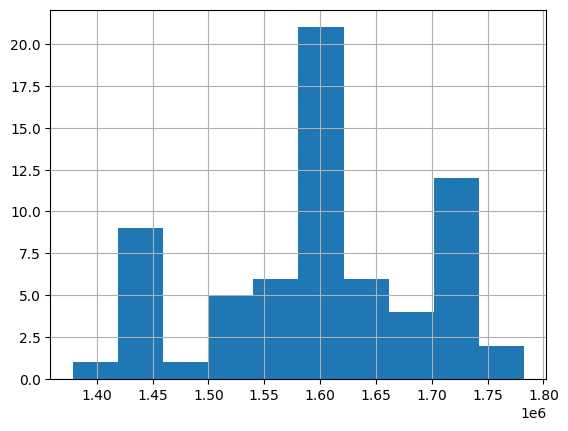

In [46]:
raw_sampleset = sampler.sample_cqm(model)
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
feasible_sampleset_csv = feasible_sampleset.to_pandas_dataframe(True)
feasible_sampleset_csv.energy.hist()
print(f'Minimum energy {feasible_sampleset_csv.energy.min()}')

The $LeapHybridCQMSampler$ can provide multiple solutions to an optimization problem with slightly different energy levels due to quantum fluctuations. This is because the quantum annealer can explore multiple low-energy states (local minima) simultaneously. By providing multiple solutions, the sampler offers a range of potential outcomes, allowing users to analyze the solution space more comprehensively. We are only interested in the solution with lower energy.

8. Unpack results

In [47]:
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = samples.truncate(10)

best_sample = best_samples.first.sample

# Separate variables into dictionaries
commit_results = {}
gen_results = {}
start_results = {}
shut_results = {}

for key, value in best_sample.items():
    if key.startswith('commit'):
        commit_results[key] = value
    elif key.startswith('gen'):
        gen_results[key] = value
    elif key.startswith('start'):
        start_results[key] = value
    elif key.startswith('shut'):
        shut_results[key] = value

In [48]:
# Prepare the data
gens = []
times = []
energies = []
resource = []
status = []
cost = best_samples.first.energy

# append the values
for key, value in gen_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    gens.append(int(generator))
    times.append(int(time))
    energies.append(value)
    resource.append(generators['Resource'][int(generator)])

# Create a DataFrame
results = pd.DataFrame({
    'Generator': gens,
    'Resource' : resource,
    'Time': times,
    'Variables': len(best_samples.variables),
    'Generated Energy annealer': energies,
    'Status annealer': None,
    'Start annealer': None,
    'Shut annealer': None,
    'Cost annealer': cost
})

for key, value in commit_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = results[(results['Generator'] == int(generator)) & (results['Time'] == int(time))].index[0]
    results.loc[row_index, 'Status annealer'] = value

for key, value in start_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = results[(results['Generator'] == int(generator)) & (results['Time'] == int(time))].index[0]
    results.loc[row_index, 'Start annealer'] = value

for key, value in shut_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    row_index = results[(results['Generator'] == int(generator)) & (results['Time'] == int(time))].index[0]
    results.loc[row_index, 'Shut annealer'] = value

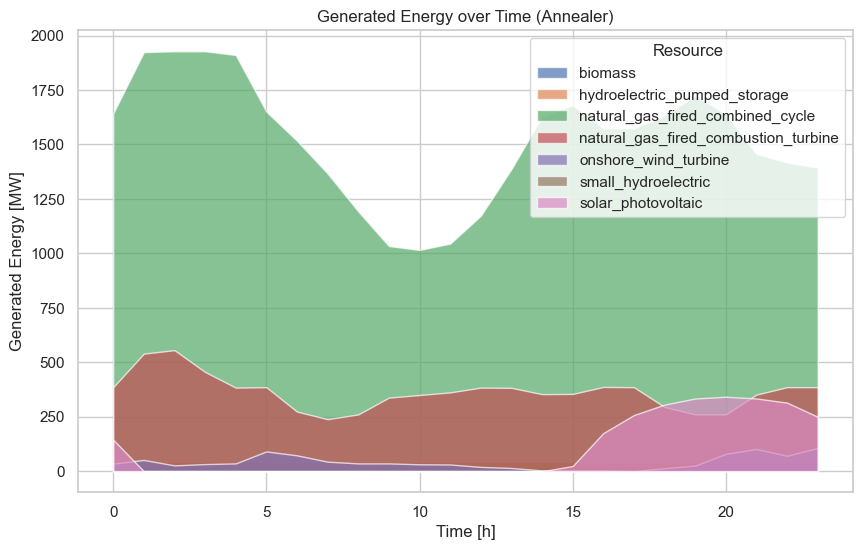

In [49]:
# Group by 'Generator' and 'Time', then sum the 'Energy' for each group
summed_df = results.groupby(['Resource', 'Time'])['Generated Energy annealer'].sum().reset_index()

# Sort the DataFrame by the Resource and Time columns
summed_df.sort_values(['Resource', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
for resource, df_group in summed_df.groupby('Resource'):
    plt.fill_between(df_group['Time'], df_group['Generated Energy annealer'], label=resource, alpha=0.7)
plt.xlabel('Time [h]')
plt.ylabel('Generated Energy [MW]')
plt.title('Generated Energy over Time (Annealer)')
plt.legend(title='Resource')
plt.show()

### 4. Classical implementation

We will solve the UC problem classically using the PuLP library, a high-level modeling tool for linear and mixed-integer linear programming (MILP) problems. It acts as an interface to various solvers, allowing to model optimization problems and then delegate the solving process to external solver engines. The choice of solver is essential to the solution process, and PuLP supports several solvers, including open-source solvers like CBC, GLPK, and commercial solvers like CPLEX and Gurobi. The solver determines the algorithm and techniques used to solve the MILP problem.


1. Define the variables

In [50]:
# Create a MILP problem
prob = LpProblem("Unit_Commitment_Problem", LpMinimize)

# Decision variables
commit = LpVariable.dicts("commit", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
gen = LpVariable.dicts("gen", [(generator, t) for generator, rows in generators.iterrows() for t in range(n_hours)], cat="Integer")
start = LpVariable.dicts("start", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
shut = LpVariable.dicts("shut", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")

2. Define the objective function

In [51]:
# Initialize lists to store linear expressions for each term
non_varying_terms = []
varying_terms = []
thermal_terms = []

# non-varying generators
for generator, row in non_var_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = row['Heat_rate_MMBTU_per_MWh']
        fuel_cost = row['Cost_per_MMBtu']
        VarOM = row['Var_OM_cost_per_MWh']
        non_varying_terms.append((heat_rate * fuel_cost + VarOM) * gen[generator, hour])

# varying generators
for generator, row in var_generators.iterrows():
    for hour in range(n_hours):
        VarOM = row['Var_OM_cost_per_MWh']
        varying_terms.append(VarOM * gen[generator, hour])

# thermal generators
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        existing_cap = row['Existing_Cap_MW']
        start_cost = row['Start_cost_per_MW']
        thermal_terms.append(existing_cap * start_cost * start[generator, hour])

# Add all terms using lpSum
total_obj = lpSum(non_varying_terms) + lpSum(varying_terms) + lpSum(thermal_terms)
prob += total_obj

3. Define energy demand constraints

In [52]:
# Supply must = demand in all time periods
for hour in range(n_hours):
    sum_energies = lpSum(gen[generator, hour] for generator, _ in generators.iterrows())
    prob += (sum_energies == day_demand[hour])

4. Define capacity constraints

In [53]:
# thermal generators requiring commitment
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']

        prob += lpSum([gen[generator, hour] - commit[generator, hour] * existing_cap * min_power]) >= 0
        prob += lpSum([gen[generator, hour] - commit[generator, hour] * existing_cap]) <= 0

In [54]:
# non-variable generation not requiring commitment
for hour in range(n_hours):
    for generator, row in non_thermal_non_var_generators.iterrows():
        existing_cap = row['Existing_Cap_MW_x']
        prob += lpSum([gen[generator, hour] - existing_cap]) <= 0

In [55]:
# variable generation, accounting for hourly capacity factor
for hour in range(n_hours):
    for generator, row in var_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        name = str(row['region']) + '_' + str(row['Resource']) + '_1.0'
        variability = generators_variability.loc[(generators_variability['Generator'] == name) & 
        (generators_variability['Hour'] == hour +1), 'Variability'].values[0]

        prob += lpSum([gen[generator, hour] - existing_cap * variability]) <= 0

5. Define unit commitment constraints

In [56]:
# minimum up and down time
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        if hour >= row['Up_time']:
            prob += lpSum(commit[generator, hour] - sum(start[generator, t] for t in range(hour - row['Up_time'], hour))) >= 0

        if hour >= row['Down_time']:
            prob += lpSum(1 - commit[generator, hour] - sum(shut[generator, t] for t in range(hour - row['Down_time'], hour))) <= 0

In [57]:
# Commmitment state
for hour in range(1, n_hours):
    for generator, row in thermal_generators.iterrows():
        prob += lpSum(commit[generator, hour]  - commit[generator, hour - 1] - start[generator, hour] + shut[generator, hour]) == 0

6. Solve the problem

In [58]:
# Solve the problem
prob.solve()

# Check the solution status
if LpStatus[prob.status] == 'Optimal':
    # Retrieve the optimal solution
    commit_solution = {(generator, t): commit[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    gen_solution = {(generator, t): gen[generator, t].varValue for generator, row in generators.iterrows() for t in range(n_hours)}
    start_solution = {(generator, t): start[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    shut_solution = {(generator, t): shut[generator, t].varValue for generator, row in thermal_generators.iterrows() for t in range(n_hours)}
    total_cost = prob.objective.value()
    print("Optimal solution found")
    print("Total cost:", total_cost)
else:
    print("No solution found")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/e906f03452954c3788462ad21121fd7d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/e906f03452954c3788462ad21121fd7d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2449 COLUMNS
At line 14426 RHS
At line 16871 BOUNDS
At line 18912 ENDATA
Problem MODEL has 2444 rows, 2040 columns and 6912 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.31921e+06 - 0.02 seconds
Cgl0003I 337 fixed, 372 tightened bounds, 3 strengthened rows, 359 substitutions
Cgl0003I 16 fixed, 4 tightened bounds, 0 strengthened rows, 331 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 127 strengthene

In [59]:
results['Generated Energy classical'] = [gen_solution.get((row['Generator'], row['Time']), None) for index, row in results.iterrows()]
results['Generator status classical'] = [commit_solution.get((row['Generator'], row['Time']), None) for index, row in results.iterrows()]
results['Generator start classical'] = [start_solution.get((row['Generator'], row['Time']), None) for index, row in results.iterrows()]
results['Generator shut classical'] = [shut_solution.get((row['Generator'], row['Time']), None) for index, row in results.iterrows()]
results['Classical cost'] = total_cost

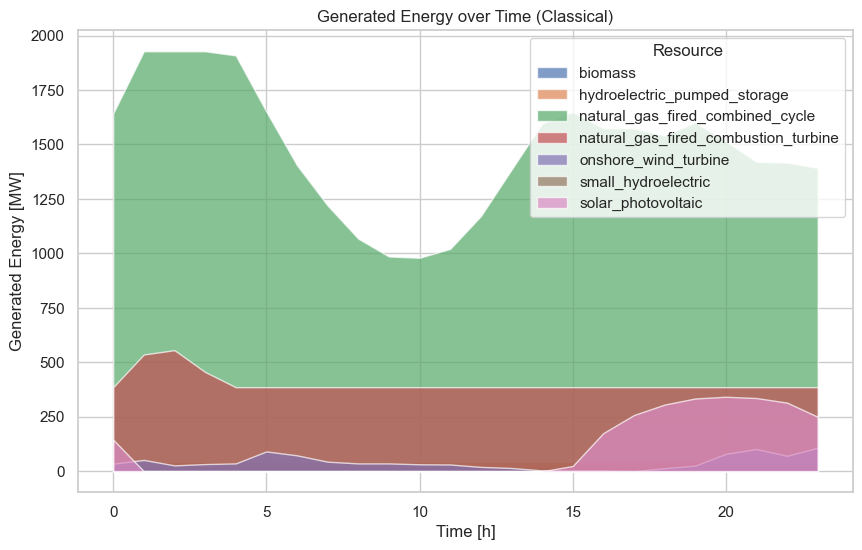

In [64]:
# Group by 'Generator' and 'Time', then sum the 'Energy' for each group
summed_df = results.groupby(['Resource', 'Time'])['Generated Energy classical'].sum().reset_index()

# Sort the DataFrame by the Resource and Time columns
summed_df.sort_values(['Resource', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
for resource, df_group in summed_df.groupby('Resource'):
    plt.fill_between(df_group['Time'], df_group['Generated Energy classical'], label=resource, alpha=0.7)
plt.xlabel('Time [h]')
plt.ylabel('Generated Energy [MW]')
plt.title('Generated Energy over Time (Classical)')
plt.legend(title='Resource')
plt.show()

## References
[1] A. Bhardwaj, Vikram Kumar Kamboj, Vijay Kumar Shukla, B. Singh and P. Khurana, [Unit commitment in electrical power system-a literature review](https://ieeexplore.ieee.org/abstract/document/6230874), 2012 IEEE International Power Engineering and Optimization Conference Melaka, Malaysia, Melaka, Malaysia, 2012, pp. 275-280, doi: 10.1109/PEOCO.2012.6230874.

[2] L. Andrew, [Ising formulations of many NP problems](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005), Frontiers in Physics, 2, 2014, doi: 10.3389/fphy.2014.00005  

[3] S. Golestan, M.R. Habibi, S.Y. Mousazadeh Mousavi, J.M. Guerrero, J.C. Vasquez, [Quantum computation in power systems: An overview of recent advances](https://www.sciencedirect.com/science/article/pii/S2352484722025720), Energy Reports, Volume 9, 2023, doi: https://doi.org/10.1016/j.egyr.2022.11.185. 